In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# %matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
from shell.fleet.comm_constraints import *
import seaborn as sns
from analyze_budget import *
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_909536/3731831139.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [30]:
error_type = 'sem'
metric = 'auc'
metric = 'final_acc'
multi_dataset=False

In [31]:
def cal_mean_and_error(df, keys=None, metric=None,
                      error_type="sem"):
   if keys is None:
      keys = ["algo", "use_contrastive"]
   if metric is None:
      metric = "final_acc"
   keys += ["dataset"]
   m = df.groupby(keys)[
         metric].mean()
   if error_type == "sem":
      stderr = df.groupby(keys)[metric].sem()
   else:
      stderr = df.groupby(keys)[metric].std()
   df = pd.DataFrame(m).reset_index()
   df[metric + "_error"] = stderr.values
   return df


In [32]:
def normalize_by_baseline(df):
    """
    Normalize a specified 'metric' in the DataFrame by the baseline values for 'modular' and 'monolithic'.
    
    Args:
    df (pd.DataFrame): DataFrame containing the data.
    metric (str): The name of the metric column to normalize.

    Returns:
    pd.DataFrame: A DataFrame with the normalized metric.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    df_normalized = df.copy()
    
    # Identify the baseline values for modular and monolithic
    modular_baseline = df_normalized[df_normalized['algo'] == 'modular (baseline)'].set_index('dataset')[metric]
    monolithic_baseline = df_normalized[df_normalized['algo'] == 'monolithic (baseline)'].set_index('dataset')[metric]

    # Function to apply normalization based on 'algo' field
    def normalize_row(row):
        if 'modular' in row['algo'] or 'modmod' in row['algo']:
            return (row[metric] - modular_baseline[row['dataset']])/ modular_baseline[row['dataset']]
        elif 'monolithic' in row['algo']:
            return (row[metric] - monolithic_baseline[row['dataset']]) / monolithic_baseline[row['dataset']]
        return row[metric]

    # Apply normalization
    df_normalized[metric] = df_normalized.apply(normalize_row, axis=1)
    
    return df_normalized


def map_datasets_to_new_groups(df):
    """Map original dataset names to new group names 'homo' or 'hetero'."""
    if multi_dataset:
        dataset_group_map = {
            'mnist': 'homogenous', 'fashionmnist': 'homogenous', 'kmnist': 'homogenous',
            'cifar100': 'cifar100', 'combined': 'combined'
        }

    else:
        dataset_group_map = {
                'mnist': 'avg', 'fashionmnist': 'avg', 'kmnist': 'avg',
                'cifar100': 'avg', 'combined': 'avg'
            }
    df['dataset'] = df['dataset'].map(dataset_group_map)
    return df

def aggregate_by_new_groups(df):
    """Aggregate DataFrame by taking the mean over new dataset groups 'homo' and 'hetero'."""
    # Group by all columns except 'value', take mean, and reset index
    group_cols = [col for col in df.columns if col != metric and col != (metric + '_error')]
    group_cols = ['dataset', 'use_contrastive', 'algo', 'comm_cost']
    print(group_cols)
    return df.groupby(group_cols).mean().reset_index()

In [33]:
def process_recv_df(df, error_type='std', has_offset=True):
    regex = r'^(?P<algo>modular|monolithic).*comm_freq_(?P<comm_freq>\d+)_num_queries_(?P<num_queries>\d+)$'


    heuristic_regex = r'^(?P<algo>\w+)_heuristic_budget_(?P<budget>\d+).*_comm_freq_(?P<comm_freq>\d+)$'

    df = df[df['use_contrastive'] == False]
    

    df = cal_mean_and_error(df, metric=metric, error_type=error_type)

    df_heur = df[df['algo'].str.contains('heuristic')]
    df = df[~df['algo'].str.contains('heuristic')]
    # NOTE: manual, but kinda hacky code. We want to manually remove those dataset=cifar100 and algo=monolithic
    # from df
    df = df[~((df['dataset'] == 'cifar100') & (df['algo'].str.contains('monolithic')))]


    # # Extract and assign the new columns
    df[['algo', 'comm_freq', 'num_queries']] = df['algo'].str.extract(regex)

    df_heur[['algo', 'budget', 'comm_freq']] = df_heur['algo'].str.extract(heuristic_regex)
    df_heur['budget'] = df_heur['budget'].astype(int)
    no_neighbors = 5

    df_heur['num_queries'] = df_heur['budget'] / no_neighbors

    df = pd.concat([df, df_heur])

    # Convert 'comm_freq' and 'num_queries' to integer
    df['comm_freq'] = df['comm_freq'].astype(int)
    df['num_queries'] = df['num_queries'].astype(int)

    num_epochs = 100
    df['num_comms_per_task'] = num_epochs // df['comm_freq']
    if has_offset:
        df['num_comms_per_task'] -= 1
    df['comm_freq'] = df['num_comms_per_task'].astype(int)
    
    df['data_pt_size'] = df.apply(
        lambda x: compute_data_pt_size(dataset=x['dataset']),
        axis=1
    )


    df['comm_cost'] = df.apply(
        lambda x: compute_receiver_cost(x['num_queries'], no_neighbors, x['data_pt_size'], x['comm_freq']),
        axis=1
    )

    df['log_comm_cost'] = np.log(df['comm_cost'])

    df['algo'] = df['algo'].apply(lambda x: x + ' data')


    return df


In [34]:
def process_fedavg_df(df, error_type='std'):
    regex = r'^(?P<algo>modular|monolithic).*comm_freq_(?P<comm_freq>\d+)$'

    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, metric=metric, error_type=error_type)
    # Extract and assign the new columns
    df[['algo', 'comm_freq']]= df['algo'].str.extract(regex)

    # # Convert 'comm_freq' and 'num_queries' to integer
    df['comm_freq'] = df['comm_freq'].astype(int)
    # # we have comm_freq = num_epochs // (num_comms_per_task + 1)
    num_epochs = 100
    df['num_comms_per_task'] = num_epochs // df['comm_freq']
    df['comm_freq'] = df['num_comms_per_task'].astype(int)


    df['model_size'] = df.apply(
        lambda x: compute_mlp_model_size(layer_size=64, num_modules=4) if x['dataset'] != 'cifar100' else compute_cnn_model_size(),
        axis=1
    )

    df['comm_cost'] = df.apply(
        lambda x: compute_fedavg_cost(x['model_size'], x['comm_freq']),
        axis=1
    )


    df['log_comm_cost'] = np.log(df['comm_cost'])
    df['algo'] = df['algo'].apply(lambda x: x + ' FedAvg')
    return df

In [35]:
def process_vanilla_df(df, error_type='std'):
    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, metric=metric, error_type=error_type)
    df['algo'] = df['algo'].apply(lambda x: x + ' (baseline)')
    df['log_comm_cost'] = 0.0
    df['comm_cost'] = 0.0
    df['comm_freq'] = 0
    return df

In [36]:
def process_modmod_df(df, error_type='std'):
    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, metric=metric, error_type=error_type)

    regex = r'^(?P<algo>modular).*num_shared_modules_(?P<num_shared_modules>\d+)'
    df[['algo', 'num_shared_modules']]= df['algo'].str.extract(regex)

    df['num_shared_modules'] = df['num_shared_modules'].astype(int)

    df['comm_cost'] = df.apply(
        lambda x: compute_mlp_model_size(layer_size=64, num_modules=x['num_shared_modules']) if x['dataset'] != 'cifar100' else compute_cnn_model_size(num_modules=x['num_shared_modules']),
        axis=1
    )


    df['log_comm_cost'] = np.log(df['comm_cost'])
    df['algo'] = df['algo'].apply(lambda x: 'modmod')
    return df


In [37]:
recv_df = pd.read_csv('budget_experiment_results/jorge_setting_recv_variable_shared_memory_size.csv')
recv_df = process_recv_df(recv_df, error_type=error_type)

In [38]:
# remove rows taht has datasets == 'fashionmnist' and algo == 'monolithic data' from recv_df
recv_df = recv_df[~((recv_df['dataset'] == 'fashionmnist') & (recv_df['algo'] == 'monolithic data'))]
recv_df = recv_df[~((recv_df['dataset'] == 'cifar100') & (recv_df['algo'] == 'modular data'))]
recv_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,comm_freq,num_queries,budget,num_comms_per_task,data_pt_size,comm_cost,log_comm_cost
0,modular data,False,combined,0.903523,0.002061,5,20,NaN,5,784,470400,13.061339
1,modular data,False,fashionmnist,0.938691,0.002722,5,20,NaN,5,784,470400,13.061339
2,modular data,False,kmnist,0.830819,0.002490,5,20,NaN,5,784,470400,13.061339
3,modular data,False,mnist,0.948369,0.001553,5,20,NaN,5,784,470400,13.061339
4,modular data,False,combined,0.905174,0.001981,10,10,NaN,10,784,470400,13.061339
...,...,...,...,...,...,...,...,...,...,...,...,...
47,monolithic data,False,cifar100,0.658966,0.001707,1,8,40.0,1,3072,147456,11.901285
48,monolithic data,False,cifar100,0.675262,0.001789,10,8,40.0,10,3072,1474560,14.203870
49,monolithic data,False,cifar100,0.683981,0.001589,5,16,80.0,5,3072,1474560,14.203870
50,monolithic data,False,cifar100,0.673737,0.001571,1,16,80.0,1,3072,294912,12.594432


In [39]:
recv_df['algo'].unique()

array(['modular data', 'monolithic data'], dtype=object)

In [40]:
fashion_recv_df = pd.read_csv('rerun_fashionmnist_recv_results.csv')
fashion_recv_df = process_recv_df(fashion_recv_df, error_type=error_type)
recv_df = pd.concat([recv_df, fashion_recv_df])

In [41]:
analyze_multiple('modular_backward_cifar_heuristic_results_small_mem_32/budget')

In [42]:
cifar_recv_df = pd.read_csv('modular_backward_cifar_heuristic_results_small_mem_32/budget.csv')
cifar_recv_df  = process_recv_df(cifar_recv_df, error_type=error_type, has_offset=False)
recv_df = pd.concat([recv_df, cifar_recv_df])

In [43]:
fed_df = pd.read_csv('budget_experiment_results/jorge_setting_fedavg.csv')
fed_df = process_fedavg_df(fed_df, error_type=error_type)
fed_df = fed_df[~(fed_df['algo'].str.contains('modular') & fed_df['dataset'].isin(['combined', 'cifar100']))]
fed_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,comm_freq,num_comms_per_task,model_size,comm_cost,log_comm_cost
2,modular FedAvg,False,fashionmnist,0.931717,0.003734,10,10,16640,166400,12.022150
3,modular FedAvg,False,kmnist,0.800666,0.003870,10,10,16640,166400,12.022150
4,modular FedAvg,False,mnist,0.939393,0.001560,10,10,16640,166400,12.022150
7,modular FedAvg,False,fashionmnist,0.931692,0.003764,1,1,16640,16640,9.719565
8,modular FedAvg,False,kmnist,0.800577,0.003869,1,1,16640,16640,9.719565
9,modular FedAvg,False,mnist,0.939397,0.001556,1,1,16640,16640,9.719565
12,modular FedAvg,False,fashionmnist,0.931680,0.003754,5,5,16640,83200,11.329003
13,modular FedAvg,False,kmnist,0.800612,0.003857,5,5,16640,83200,11.329003
14,modular FedAvg,False,mnist,0.939337,0.001517,5,5,16640,83200,11.329003
17,modular FedAvg,False,fashionmnist,0.932277,0.003658,20,20,16640,332800,12.715297


In [44]:
fedprox_df = pd.read_csv('budget_fedprox_results.csv')
fedprox_df = process_fedavg_df(fedprox_df, error_type=error_type)
fedprox_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,comm_freq,num_comms_per_task,model_size,comm_cost,log_comm_cost
0,modular FedAvg,False,cifar100,0.709378,0.001404,10,10,90200,902000,13.712370
1,modular FedAvg,False,combined,0.883664,0.003622,10,10,16640,166400,12.022150
2,modular FedAvg,False,cifar100,0.709273,0.001596,1,1,90200,90200,11.409785
3,modular FedAvg,False,combined,0.883868,0.003613,1,1,16640,16640,9.719565
4,modular FedAvg,False,cifar100,0.710588,0.001456,5,5,90200,451000,13.019223
5,modular FedAvg,False,combined,0.883783,0.003622,5,5,16640,83200,11.329003
6,modular FedAvg,False,cifar100,0.711078,0.001385,20,20,90200,1804000,14.405517
7,modular FedAvg,False,combined,0.883873,0.003606,20,20,16640,332800,12.715297
8,modular FedAvg,False,cifar100,0.709280,0.001427,2,2,90200,180400,12.102932
9,modular FedAvg,False,combined,0.883735,0.003620,2,2,16640,33280,10.412712


In [45]:
vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
vanilla_df = process_vanilla_df(vanilla_df, error_type=error_type)
vanilla_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,log_comm_cost,comm_cost,comm_freq
0,modular (baseline),False,cifar100,0.700353,0.001357,0.0,0.0,0
1,modular (baseline),False,combined,0.885849,0.003560,0.0,0.0,0
2,modular (baseline),False,fashionmnist,0.928013,0.003087,0.0,0.0,0
3,modular (baseline),False,kmnist,0.806317,0.003094,0.0,0.0,0
4,modular (baseline),False,mnist,0.934668,0.002005,0.0,0.0,0
5,monolithic (baseline),False,cifar100,0.631084,0.003176,0.0,0.0,0
6,monolithic (baseline),False,combined,0.865895,0.003669,0.0,0.0,0
7,monolithic (baseline),False,fashionmnist,0.924673,0.003335,0.0,0.0,0
8,monolithic (baseline),False,kmnist,0.782273,0.003078,0.0,0.0,0
9,monolithic (baseline),False,mnist,0.919588,0.002693,0.0,0.0,0


In [46]:
modmod_df = pd.read_csv('budget_experiment_results/modmod.csv')
modmod_df = process_modmod_df(modmod_df, error_type)
modmod_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,num_shared_modules,comm_cost,log_comm_cost
0,modmod,False,combined,0.895478,0.003131,1,4160,8.333270
1,modmod,False,combined,0.893199,0.003243,2,8320,9.026418
2,modmod,False,combined,0.895543,0.003232,3,12480,9.431883
3,modmod,False,combined,0.894780,0.003200,4,16640,9.719565
4,modmod,False,cifar100,0.727209,0.001064,1,22550,10.023490
5,modmod,False,fashionmnist,0.932812,0.003975,1,4160,8.333270
6,modmod,False,kmnist,0.818337,0.002693,1,4160,8.333270
7,modmod,False,mnist,0.940794,0.001804,1,4160,8.333270
8,modmod,False,cifar100,0.731717,0.001366,2,45100,10.716638
9,modmod,False,fashionmnist,0.939634,0.003307,2,8320,9.026418


In [47]:
df = pd.concat([recv_df, fed_df, vanilla_df, modmod_df, fedprox_df])

In [48]:
import matplotlib.pyplot as plt

def plot(df, metric, colormap, markermap, include_err=False, figsize=(40, 10), plot_baseline=False,
    y_label="Final Avg Test Accuracy"):
    datasets = df['dataset'].unique()
    algos = df['algo'].unique()
    fig, ax = plt.subplots(1, len(datasets), figsize=figsize)
    if len(datasets) == 1:
        ax = [ax]

    handles, labels = [], []
    error_metric = metric + '_error'
    for i, dataset in enumerate(sorted(datasets)[::-1]):
        d_df = df[df['dataset'] == dataset]

        ax[i].axhline(y=0, color='black', linewidth=1.5, linestyle='--', alpha=0.5)
        for algo in sorted(algos):  # Sorting for consistent plotting
            subset = d_df[d_df['algo'] == algo]
            if 'baseline' in algo:
                if plot_baseline:
                    # Plot dashed horizontal line for each baseline
                    mean_value = subset[metric].mean()
                    line = ax[i].axhline(y=mean_value, color=colormap[algo], label=algo, linewidth=2.5, linestyle='--')
                    if algo not in labels:  # Avoid duplicate labels in the legend
                        handles.append(line)
                        labels.append(algo)
            else:
                err = subset[error_metric].values  # Assuming the DataFrame contains error values

                if include_err:
                    errorbar = ax[i].errorbar(subset['log_comm_cost'], subset[metric],
                                yerr=err, fmt='o', color=colormap[algo], label=algo,
                                markersize=10, alpha=0.8, elinewidth=2,
                                marker=markermap[algo])
                else:
                    errorbar = ax[i].scatter(subset['log_comm_cost'], subset[metric],
                              color=colormap[algo], label=algo, s=150, alpha=0.8,
                              marker=markermap[algo])
                if algo not in labels:  # Avoid duplicate labels in the legend
                    handles.append(errorbar)
                    labels.append(algo)



        ax[i].set_title(f'{dataset}', fontsize=20)
        ax[i].tick_params(axis='x', labelsize=16)
        ax[i].tick_params(axis='y', labelsize=16)
        ax[i].grid(True, which='major', linestyle='--', alpha=0.5)

    latex_metric = metric.replace('_', '\_')
    # fig.suptitle(r'Comparing methods under different budget $\mathsf{'+latex_metric+'}$', fontsize=30, weight='bold')
    fig.suptitle(r'Comparing methods under different budget', fontsize=30, weight='bold')
    fig.text(0.5, 0.02, 'Log(communication cost)', ha='center', va='center', fontsize=20, weight='bold')
    # fig.text(0.02, 0.5, metric, ha='center', va='center', rotation='vertical', fontsize=20, weight='bold')
    fig.text(0.02, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=20, weight='bold')
    fig.legend(handles, labels, loc='lower right', fontsize=20, frameon=True, bbox_to_anchor=(1.1, 0.0))
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    
    plt.savefig("Figures/budget.pdf", bbox_inches="tight")

# Usage of this function will require a DataFrame `df` with columns 'dataset', 'algo', 'log_comm_cost', and the specific 'metric'.
# You will also need to provide a `colormap` dictionary mapping each algorithm to a color.


In [49]:
from sklearn.linear_model import LinearRegression

def fit_model_and_extract_slope(data, metric):
    model = LinearRegression()
    X = data['log_comm_cost'].values.reshape(-1, 1)
    y = data[metric].values.reshape(-1, 1)
    model.fit(X, y)
    return model, model.coef_[0][0]  # Slope of the fitted line

In [50]:
def compute_value_of_information(df, metric):
    results = {}
    algos = df['algo'].unique()
    for algo in algos:
        if 'baseline' not in algo:
            data = df[df['algo'] == algo]
            if len(data) > 1:
                slope = fit_model_and_extract_slope(data, metric)
                results[algo] = slope
    return results

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def plot(df, metric, colormap, markermap, include_err=False, figsize=(40, 10), plot_baseline=False,
    y_label="Final Avg Test Accuracy", plot_at_zero=True):
    datasets = df['dataset'].unique()
    algos = df['algo'].unique()
    fig, ax = plt.subplots(1, len(datasets), figsize=figsize)
    if len(datasets) == 1:
        ax = [ax]

    handles, labels = [], []
    error_metric = metric + '_error'
    slopes = {}
    for i, dataset in enumerate(sorted(datasets)[::-1]):
        d_df = df[df['dataset'] == dataset]

        # draw hline at 0
        if plot_at_zero:
            ax[i].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
        for algo in sorted(algos):  # Sorting for consistent plotting
            subset = d_df[d_df['algo'] == algo]
            X = subset['log_comm_cost'].values.reshape(-1, 1)

            if 'baseline' in algo:
                if plot_baseline:
                    mean_value = subset[metric].mean()
                    line = ax[i].axhline(y=mean_value, color=colormap[algo], label=algo, linewidth=2.5, linestyle='--')
                    if algo not in labels:  # Avoid duplicate labels in the legend
                        handles.append(line)
                        labels.append(algo)
            else:
                if len(X) > 1:  # Ensure there are enough points to fit a line
                    model, slope = fit_model_and_extract_slope(subset, metric)
                    x_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
                    y_fit = model.predict(x_fit)
                    slopes[algo] = slope

                    # Plotting the fitted line
                    ax[i].plot(x_fit, y_fit, color=colormap[algo], label=f'{algo} Fit', linewidth=2, linestyle='-',
                    alpha=0.1)

                if include_err:
                    err = subset[error_metric].values  # Assuming the DataFrame contains error values
                    errorbar = ax[i].errorbar(subset['log_comm_cost'], subset[metric],
                                              yerr=err, fmt='o', color=colormap[algo], label=algo,
                                              markersize=10, alpha=0.8, elinewidth=2,
                                              marker=markermap[algo])
                else:
                    errorbar = ax[i].scatter(subset['log_comm_cost'], subset[metric],
                                             color=colormap[algo], label=algo, s=150, alpha=0.8,
                                             marker=markermap[algo])
                if algo not in labels:  # Avoid duplicate labels in the legend
                    handles.append(errorbar)
                    labels.append(algo)

        ax[i].set_title(f'{dataset}', fontsize=20)
        ax[i].tick_params(axis='x', labelsize=16)
        ax[i].tick_params(axis='y', labelsize=16)
        ax[i].grid(True, which='major', linestyle='--', alpha=0.5)

    fig.suptitle(r'Comparing methods under different budget', fontsize=30, weight='bold')
    fig.text(0.5, 0.02, 'Log(communication cost)', ha='center', va='center', fontsize=20, weight='bold')
    fig.text(0.02, 0.5, y_label, ha='center', va='center', rotation='vertical', fontsize=20, weight='bold')
    fig.legend(handles, labels, loc='lower right', fontsize=20, frameon=True, bbox_to_anchor=(1.1, 0.0))
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.savefig("Figures/budget.pdf", bbox_inches="tight")

    return slopes


{'modmod': 0.005630627121528948,
 'modular FedAvg': 0.0004932296165303369,
 'modular data': -0.0014865931884267324,
 'monolithic FedAvg': 0.011715222719044996,
 'monolithic data': 0.011074220446996571}

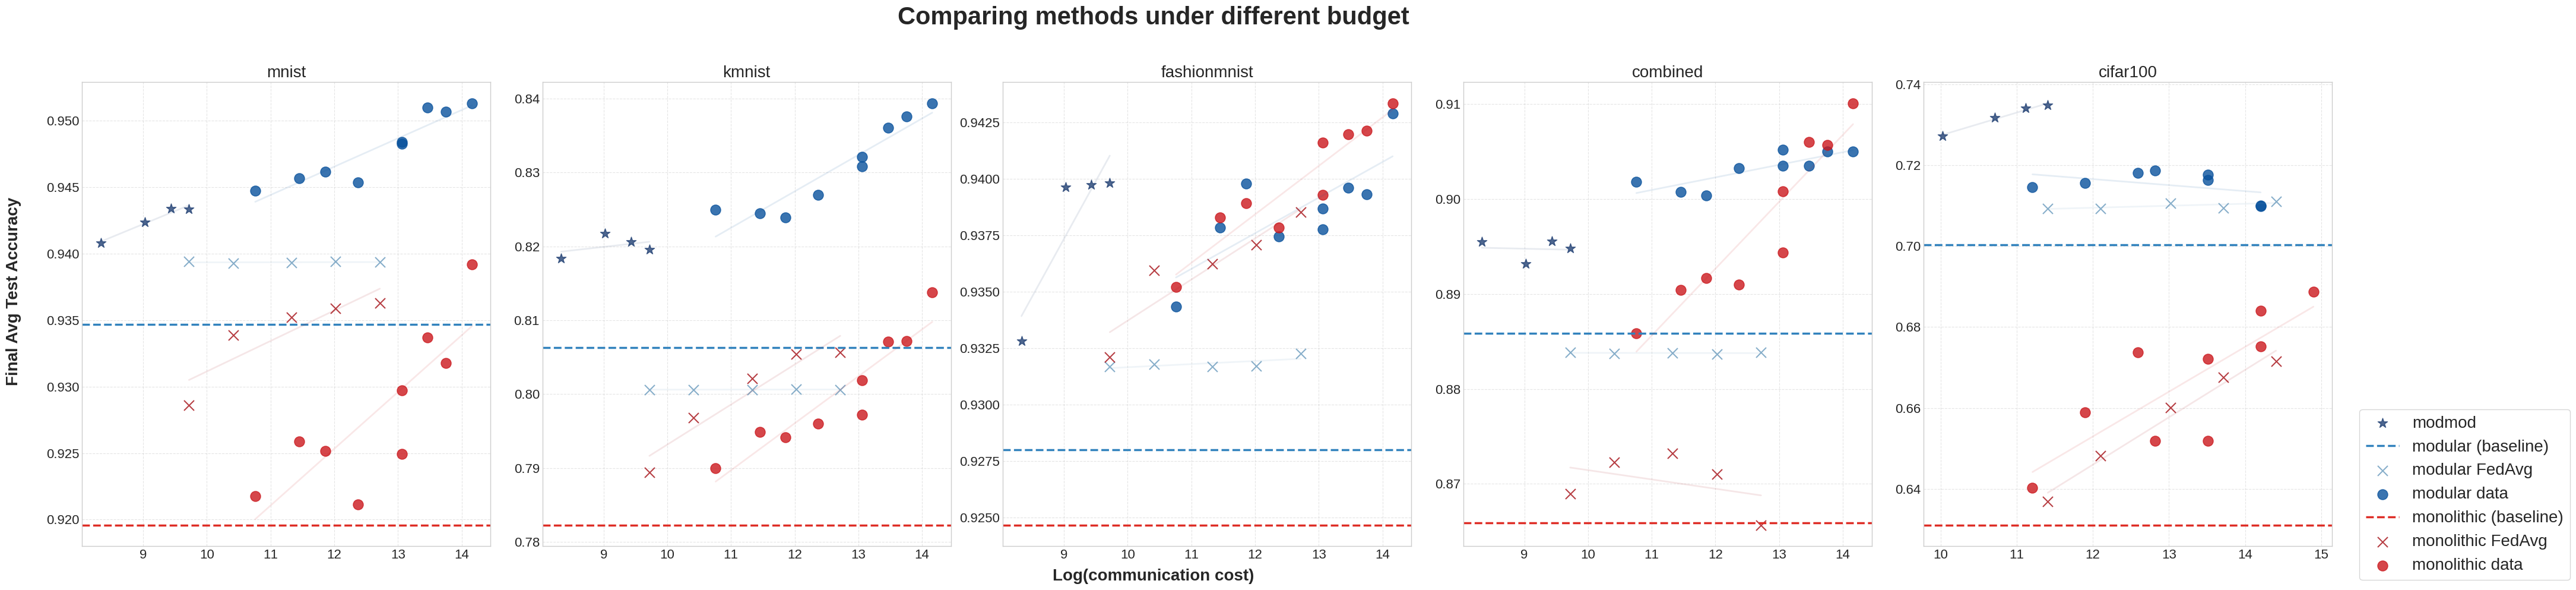

In [52]:

colormap = {
   'modular_use_contrastive:False': '#3182bd',
   'monolithic_use_contrastive:False': '#de2d26',
   'modular_modmod_use_contrastive:False':  '#214073',  # Corrected key
   'modular_fedavg_use_contrastive:False': '#6a9bbd',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': '#a50f15',  # Changed key format
   'modular_recv_use_contrastive:False': '#08519c',  # Changed key format
   'monolithic_recv_use_contrastive:False': '#cb181d',  # Changed key format
}

remap_name = {
   'modular_use_contrastive:False': 'modular (baseline)',
   'monolithic_use_contrastive:False': 'monolithic (baseline)',
   'modular_modmod_use_contrastive:False':  'modmod',  # Corrected key
   'modular_fedavg_use_contrastive:False': 'modular FedAvg',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': 'monolithic FedAvg',  # Changed key format
   'modular_recv_use_contrastive:False': 'modular data',  # Changed key format
   'monolithic_recv_use_contrastive:False': 'monolithic data',  # Changed key format
}

r_colormap = {
    remap_name[k]: v for k, v in colormap.items()
}

markermap = {
    'modular data': 'o',
    'monolithic data': 'o',

    'modular FedAvg': 'x',
    'monolithic FedAvg': 'x',

    'modmod': '*',
}

# algos = df['algo'].unique()
# # color_map = plt.cm.get_cmap('tab20b', num_colors)
# color_map = plt.cm.get_cmap('tab10', len(algos))
# colormap = {algo: color_map(i) for i, algo in enumerate(algos)}

plot(df, metric, r_colormap, markermap, plot_baseline=True, plot_at_zero=False)

['dataset', 'use_contrastive', 'algo', 'comm_cost']


{'modmod': 1.5792206633098356,
 'modular FedAvg': 0.332808620188702,
 'modular data': 0.1397247392948568,
 'monolithic FedAvg': 1.263281949453718,
 'monolithic data': 1.3838302358122023}

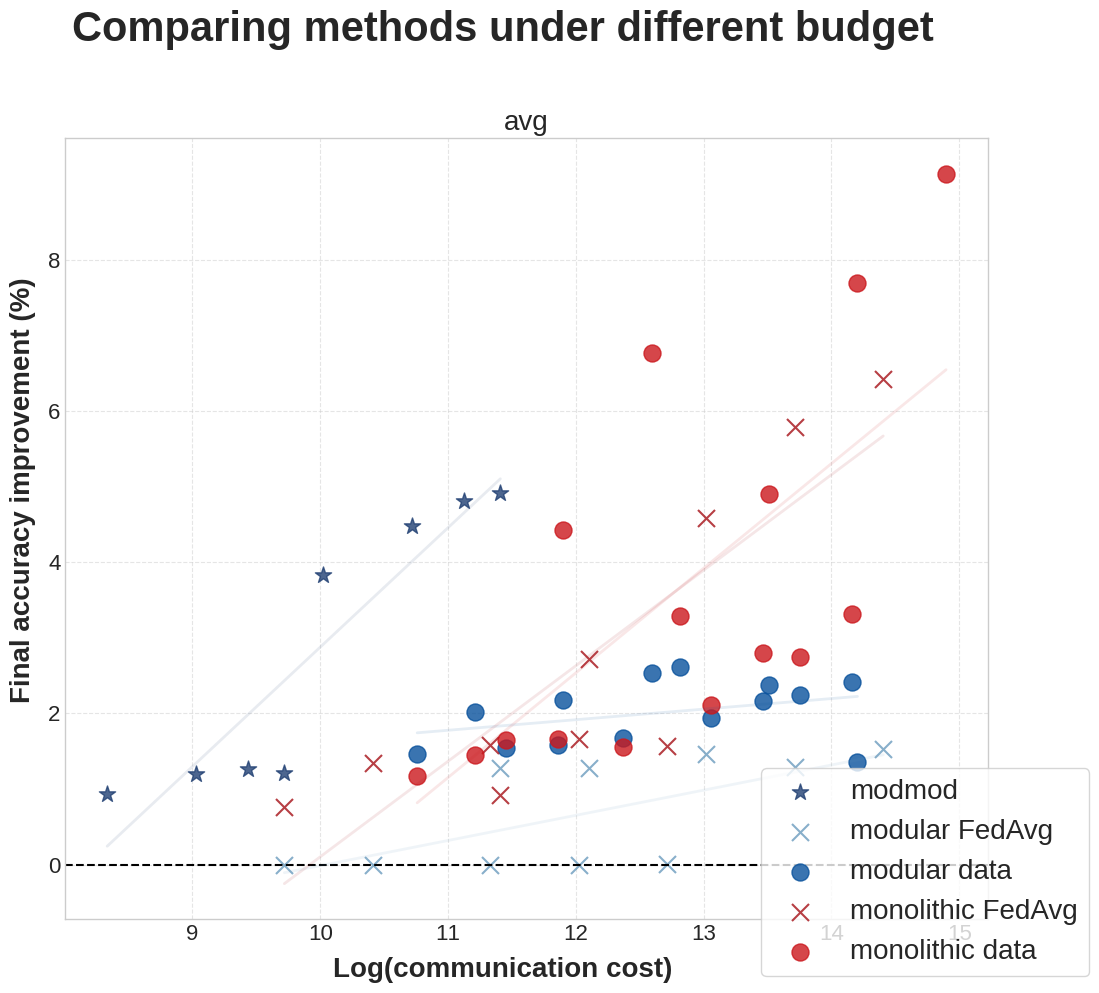

In [53]:
df_norm = normalize_by_baseline(df)
df_mapped = map_datasets_to_new_groups(df_norm.copy())
# df_mapped = df_mapped[df_mapped['dataset'] == 'homogenous']
df_avg = aggregate_by_new_groups(df_mapped)
df_avg[metric] *= 100

metric_label = {
        'auc': 'AUC',
        'final_acc': 'Final accuracy'
    }


plot(df_avg, metric, r_colormap, markermap, figsize=(10, 10),
y_label=metric_label[metric] + ' improvement (%)')

In [56]:
df_avg['value_of_info'] = df_avg[metric] / df_avg['comm_cost']

In [58]:
pd.set_option('display.precision', 10)

df_avg.groupby('algo')['value_of_info'].mean() 

algo
modmod                   0.0001173919
modular (baseline)                NaN
modular FedAvg           0.0000025670
modular data             0.0000099394
monolithic (baseline)             NaN
monolithic FedAvg        0.0000165475
monolithic data          0.0000113883
Name: value_of_info, dtype: float64